## Atividade 1

Feita baseada nos codigos disponibilizados pelo professor.

## Configurações Iniciais

Para instalar e importar pacotes e configurar algumas coisas...

In [1]:
from IPython.display import clear_output
import sys

if 'google.colab' in sys.modules:
    # clone repository, to use "util" module
    !git clone https://github.com/pablo-sampaio/rl_facil
    sys.path.append("/content/rl_facil")
    clear_output()
else:
    from os import path
    sys.path.append( path.dirname( path.dirname( path.abspath("__main__") ) ) )

In [2]:
from util.bandit_envs import MultiArmedBanditEnv, GaussianMultiArmedBanditEnv
from util.experiments import repeated_exec
from util.plot import plot_multiple_results
from cap02.baseline_algorithms import run_random
import numpy as np

## Epsilon-Greedy-Decaying

Decay do epsilon gready

In [20]:
import math

import matplotlib.pyplot as plt

class decay_epsilon_greedy:
    def __init__(self, initial_epsilon, target_step, minimum_epsilon):
        self.initial_epsilon = initial_epsilon
        self.target_step = target_step
        self.minimum_epsilon = minimum_epsilon

    def linear_decay(self, step):
        epsilon = self.initial_epsilon
        decay_rate = (self.initial_epsilon - self.minimum_epsilon) / self.target_step
        if self.target_step>=step:
          #epsilon -= self.initial_epsilon - (decay_rate * step)
          epsilon = self.initial_epsilon - (decay_rate * step)
        else:
          epsilon = self.minimum_epsilon
        return epsilon

    def exponencial_decay(self, step):
        epsilon = self.initial_epsilon
        decay_rate = (self.minimum_epsilon / self.initial_epsilon) ** (1 / self.target_step)
        if self.target_step>=step:
          epsilon *= self.initial_epsilon * (decay_rate ** step)
        else:
          epsilon = self.minimum_epsilon
        return epsilon


In [18]:
def run_epsilon_greedy(env, total_steps, epsilon_initial, target_step, minimum_epsilon, tipo_decay):
    num_actions = env.get_num_actions()
    #definindo um classe decay com os parametros
    decay = decay_epsilon_greedy(initial_epsilon=epsilon_initial, target_step=target_step, minimum_epsilon=minimum_epsilon)

    # estatisticas por ação
    Q = [0.0 for i in range(num_actions)]          # recompensa média (esperada) por ação
    action_cnt  = [0 for i in range(num_actions)]  # quantas vezes cada ação foi realizada

    env.reset()

    reward_per_step = []    # recompensas recebidas a cada passo

    for step in range(total_steps):
        #pegando o valor do epsilon com o decay
        if tipo_decay=="linear":
          epsilon = decay.linear_decay(step)
          if (step % 500) == 0:
             print("e =", epsilon)
        elif tipo_decay=="exponencial":
          epsilon = decay.exponencial_decay(step)
        # gera um valor aleatório entre 0 e 1
        # se ele ficar abaixo de "epsilon", faz ação aleatória
        if (np.random.random() <= epsilon):
            a = np.random.randint(num_actions)
        else:
            a = np.argmax(Q)

        r = env.step(a)

        reward_per_step.append(r)

        # atualiza estatísticas
        action_cnt[a] += 1

        # atualiza a recompensa média da ação
        delta = r - Q[a]
        Q[a] += (1/action_cnt[a]) * delta
        # alternativa equivalente: Q[a] = ((action_cnt[a]-1)*Q[a] + r) / action_cnt[a]

    return reward_per_step, Q

In [ ]:
run_epsilon_greedy(env, 10_000, epsilon_initial=1.0, target_step=3000, minimum_epsilon=0.02, tipo_decay='linear');

Nesta solução, um parâmetro **`epsilon`** controla o grau de exploração (*exploration*) do algoritmo, que escolhe ações assim:
- com probabilidade *epsilon*: faz uma ação qualquer
- com probabilidade *(1.0-epsilon)*: faz a ação de melhor média (até o momento)

Vamos fazer alguns experimentos, com diferentes valores dos *parâmetros*.

In [5]:
BANDIT_PROBABILITIES = [0.2, 0.5, 0.75]
env = MultiArmedBanditEnv(BANDIT_PROBABILITIES)

rewards, _ = run_epsilon_greedy(env, total_steps=10000, epsilon_initial=1, target_step=3000, minimum_epsilon=0.2, tipo_decay="linear")
print(f"Eps-greedy (0.2) - soma de recompensas:", sum(rewards))

rewards, _ = run_epsilon_greedy(env, total_steps=10000, epsilon_initial=0.8, target_step=2000, minimum_epsilon=0.1, tipo_decay="linear")
print(f"Eps-greedy (0.1) - soma de recompensas:", sum(rewards))

rewards, _ = run_epsilon_greedy(env, total_steps=10000, epsilon_initial=0.5, target_step=1000, minimum_epsilon=0.01, tipo_decay="linear")
print(f"Eps-greedy (0.01) - soma de recompensas:", sum(rewards))

Eps-greedy (0.2) - soma de recompensas: 6529.0
Eps-greedy (0.1) - soma de recompensas: 6993.0
Eps-greedy (0.01) - soma de recompensas: 7345.0


A seguir, vamos comparações entre o *epsilon-greedy-decaying* e o *random*.

In [ ]:
RUNS  = 50
STEPS = 10000

results = []
results.append( repeated_exec(RUNS, "RANDOM", run_random, env, STEPS) )

for epsilon in [0.02]: #, 0.10, 0.30]:
    results.append( repeated_exec(RUNS, f"EPS({epsilon})-GREEDY Decay Linear", run_epsilon_greedy, env, STEPS, epsilon_initial=1, target_step=3000, minimum_epsilon=epsilon, tipo_decay="linear") )
    results.append( repeated_exec(RUNS, f"EPS({epsilon})-GREEDY Decay Exponencial", run_epsilon_greedy, env, STEPS, epsilon_initial=1, target_step=3000, minimum_epsilon=epsilon, tipo_decay="exponencial") )

for (alg_name, rewards) in results:
    print()
    print("Summary for " + alg_name)
    print(" - total reward:", rewards.sum())
    print(" - avg reward (win rate):", rewards.sum() / STEPS)

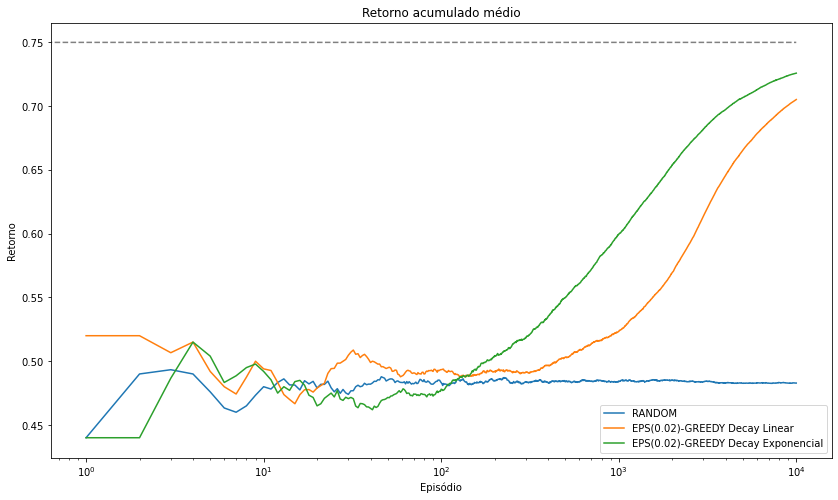

In [23]:
plot_multiple_results(results, cumulative=True, x_log_scale=True, yreference=env.get_max_mean_reward())

Gráfico com Desvio padrão

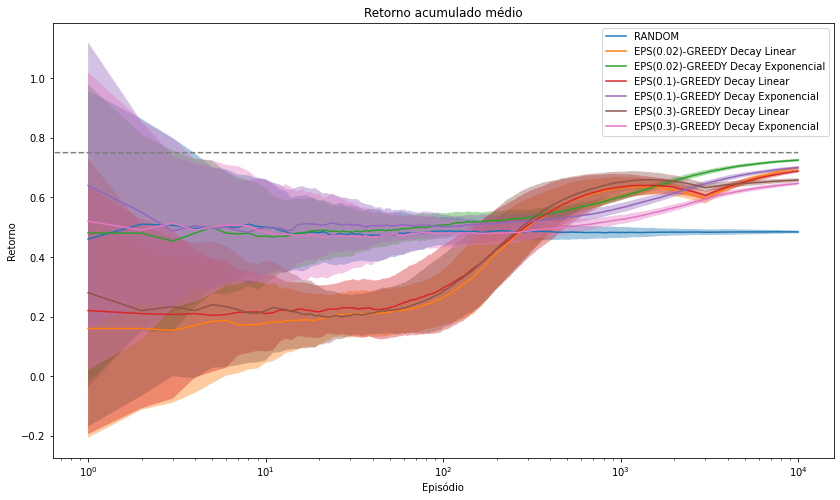

In [8]:
plot_multiple_results(results, cumulative=True, x_log_scale=True, yreference=env.get_max_mean_reward(), plot_stddev=True)